<a href="https://colab.research.google.com/github/SilverQ/dl_study/blob/master/Udacity_ud187/%E3%85%A3lab06_Transfer_Learning_with_the_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### To-do: Transfer Learning with the Inception v3 Model

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 406.5MB 43kB/s 
     |████████████████████████████████| 4.1MB 18.8MB/s 
     |████████████████████████████████| 501kB 42.9MB/s 
     |████████████████████████████████| 61kB 23.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum
     |████████████████████████████████| 81kB 1.6MB/s 
  Found existing installation: tensorflow-hub 0.5.0
    Uninstalling tensorflow-hub-0.5.0:
      Successfully uninstalled tensorflow-hub-0.5.0
     |████████████████████████████████| 942kB 1.4MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# tf.enable_eager_execution()
tf.compat.v1.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

W0725 07:09:45.997689 140510298662784 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



In [0]:
splits = tfds.Split.TRAIN.subsplit(weighted=(70, 30))

splits, dataset_info = tfds.load('tf_flowers', with_info=True,
                                 as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes

In [17]:
print(dataset_info)
print(validation_examples)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


In [18]:
def dataset_length(dataset):
    count = 0
    for image in dataset:
        count += 1
    return count

num_classes = dataset_info.features['label'].num_classes
num_training_examples = dataset_length(train_examples) # 2590
num_validation_examples = dataset_length(validation_examples) # 1080

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [19]:
for i, example_image in enumerate(train_examples.take(3)):
  print('Image {} shape {}'.format(i+1, example_image[0].shape))

Image 1 shape (240, 168, 3)
Image 2 shape (333, 500, 3)
Image 3 shape (213, 320, 3)


In [0]:
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
# URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
# feature_extractor2 = hub.KerasLayer(URL,
#                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
# NotImplementedError: TF Hub module 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1' is stored using TF 1.x format. Loading of the module using hub.load() is not supported.

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4",
                   output_shape=[2048],
                   trainable=False),  # Can be True, see below.
                   tf.keras.layers.Dense(5, activation='softmax')
])
m.build([None, 299, 299, 3])  # Batch input shape.

* Inception 참고자료([link](https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4))

In [22]:
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  21802784  
_________________________________________________________________
dense_1 (Dense)              multiple                  10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
model = m
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [24]:
EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 62s 766ms/step - loss: 1.2001 - acc: 0.5313 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 38s 464ms/step - loss: 0.7799 - acc: 0.8216 - val_loss: 0.6900 - val_acc: 0.8519
Epoch 3/6
81/81 [==============================] - 38s 467ms/step - loss: 0.6747 - acc: 0.8505 - val_loss: 0.6449 - val_acc: 0.8648
Epoch 4/6
81/81 [==============================] - 38s 468ms/step - loss: 0.6151 - acc: 0.8763 - val_loss: 0.6243 - val_acc: 0.8657
Epoch 5/6
81/81 [==============================] - 38s 465ms/step - loss: 0.5733 - acc: 0.8915 - val_loss: 0.6113 - val_acc: 0.8639
Epoch 6/6
81/81 [==============================] - 38s 468ms/step - loss: 0.5412 - acc: 0.9080 - val_loss: 0.6027 - val_acc: 0.8639


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

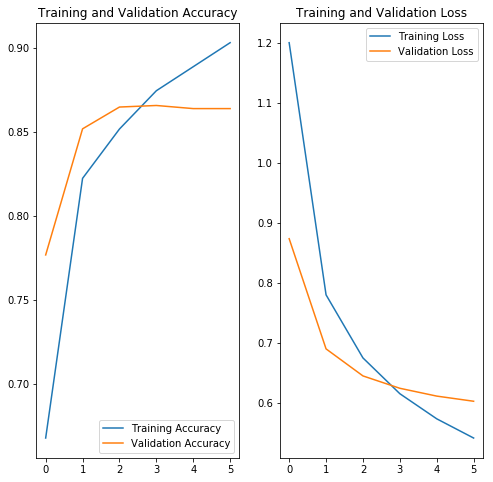

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [28]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()


predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dandelion', 'roses', 'dandelion', 'daisy', 'dandelion',
       'dandelion', 'dandelion', 'tulips', 'roses', 'sunflowers',
       'sunflowers', 'daisy', 'daisy', 'tulips', 'sunflowers', 'tulips',
       'dandelion', 'tulips', 'sunflowers', 'tulips', 'roses',
       'dandelion', 'dandelion', 'tulips', 'roses', 'roses', 'roses',
       'daisy', 'dandelion', 'roses', 'roses', 'daisy'], dtype='<U10')

In [29]:
print('Labels: ', label_batch)
print('Predicted labels: ', predicted_ids)

plt.figure(figsize=(10,9))

Labels:  [0 4 0 1 0 0 0 2 4 3 3 1 1 2 3 2 0 2 3 2 4 0 0 2 4 4 4 1 0 4 4 1]
Predicted labels:  [0 4 0 1 0 0 0 2 4 3 3 1 1 2 3 2 0 2 3 2 4 0 0 2 4 4 4 1 0 4 4 1]


<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

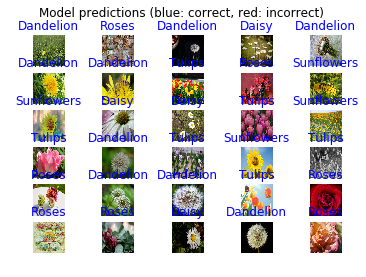

In [30]:
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")